In [3]:
# 나눔고딕 폰트 설치
!apt-get update -qq
!apt-get install fonts-nanum* -qq

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum.
(Reading database ... 123621 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-3_all.deb ...
Unpacking fonts-nanum-coding (2.5-3) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-7_all.deb ...
Unpacking fonts-nanum-eco (1.000-7) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20200506-1_all.deb ...
Unpacking fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Setting up fo

# 0. 라이브러리 및 데이터 불러오기

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

import xgboost
from xgboost import XGBClassifier

import imblearn
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

## 0-1. 버전 체크  

In [2]:
print("라이브러리 버전 체크")
print("numpy : ", np.__version__)
print("pandas : ", pd.__version__)
print("seaborn : ", sns.__version__)
print("matplotlib : ", mpl.__version__)
print("sklearn : ", sklearn.__version__)
print("xgboost : ", xgboost.__version__)
print("imblearn : ", imblearn.__version__)

라이브러리 버전 체크
numpy :  1.26.4
pandas :  2.2.2
seaborn :  0.13.2
matplotlib :  3.7.1
sklearn :  1.5.2
xgboost :  2.1.1
imblearn :  0.12.4


# 0-2. 글자 깨짐 맞추기

In [21]:
matplotlib_inline.backend_inline.set_matplotlib_formats("png2x")
mpl.style.use("default")
mpl.rcParams.update({"figure.constrained_layout.use": True})

sns.set_context("paper")
sns.set_palette("Set2")
sns.set_style("whitegrid")

import matplotlib.font_manager as fm

# 나눔고딕 폰트 경로 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fm.fontManager.addfont(font_path)
plt.rc('font', family='NanumGothic')
plt.rcParams["axes.unicode_minus"] = False

In [6]:
train = pd.read_csv("/content/hr_train_scaling.csv", index_col = 0)
test = pd.read_csv("/content/hr_test_scaling.csv", index_col = 0)

In [7]:
x_train = train[train.columns[:-1]].values
y_train = train["attrition"].values

x_test = test[test.columns[:-1]].values
y_test = test["attrition"]

In [8]:
np.unique(y_train, return_counts = True)

(array([0, 1]), array([919, 175]))

# 1. 샘플링 : ENN, SMOTE, SMOTEENN

In [10]:
enn = EditedNearestNeighbours(kind_sel="all", n_neighbors=5)
x_enn, y_enn = enn.fit_resample(x_train, y_train)

np.unique(y_enn, return_counts=True)

(array([0, 1]), array([501, 175]))

In [12]:
smo = SMOTE(random_state=0)
x_smote, y_smote = smo.fit_resample(x_train, y_train)

np.unique(y_smote, return_counts=True)

(array([0, 1]), array([919, 919]))

In [14]:
smoteenn = SMOTEENN(random_state=0)
x_smoteenn, y_smoteenn = smoteenn.fit_resample(x_train, y_train)

np.unique(y_smoteenn, return_counts=True)

(array([0, 1]), array([479, 744]))

# 2. Modeling
- HR 데이터 기준으로 여러 모델에 적용했을 때, recall 값이 가장 높았던 모델은 `DT(Decision Tree)` 였다.

In [15]:
tree = DecisionTreeClassifier(random_state=42)
tree.fit(x_train, y_train)
pred_tree = tree.predict(x_test)
print("메인 정확도 : ", accuracy_score(pred_tree, y_test))

메인 정확도 :  0.7616438356164383


In [16]:
tree_enn = DecisionTreeClassifier(random_state=42)
tree_enn.fit(x_enn, y_enn)
pred_tree_enn = tree_enn.predict(x_test)
print("enn 정확도 : ", accuracy_score(pred_tree_enn, y_test))

enn 정확도 :  0.6438356164383562


In [19]:
tree_smo = DecisionTreeClassifier(random_state=42)
tree_smo.fit(x_smote, y_smote)
pred_tree_smo = tree_smo.predict(x_test)
print("smote 정확도 : ", accuracy_score(pred_tree_smo, y_test))

smote 정확도 :  0.6958904109589041


In [18]:
tree_smoteenn = DecisionTreeClassifier(random_state=42)
tree_smoteenn.fit(x_smoteenn, y_smoteenn)
pred_tree_smoteenn = tree_smoteenn.predict(x_test)
print("smoteenn 정확도 : ", accuracy_score(pred_tree_smoteenn, y_test))

smoteenn 정확도 :  0.6520547945205479


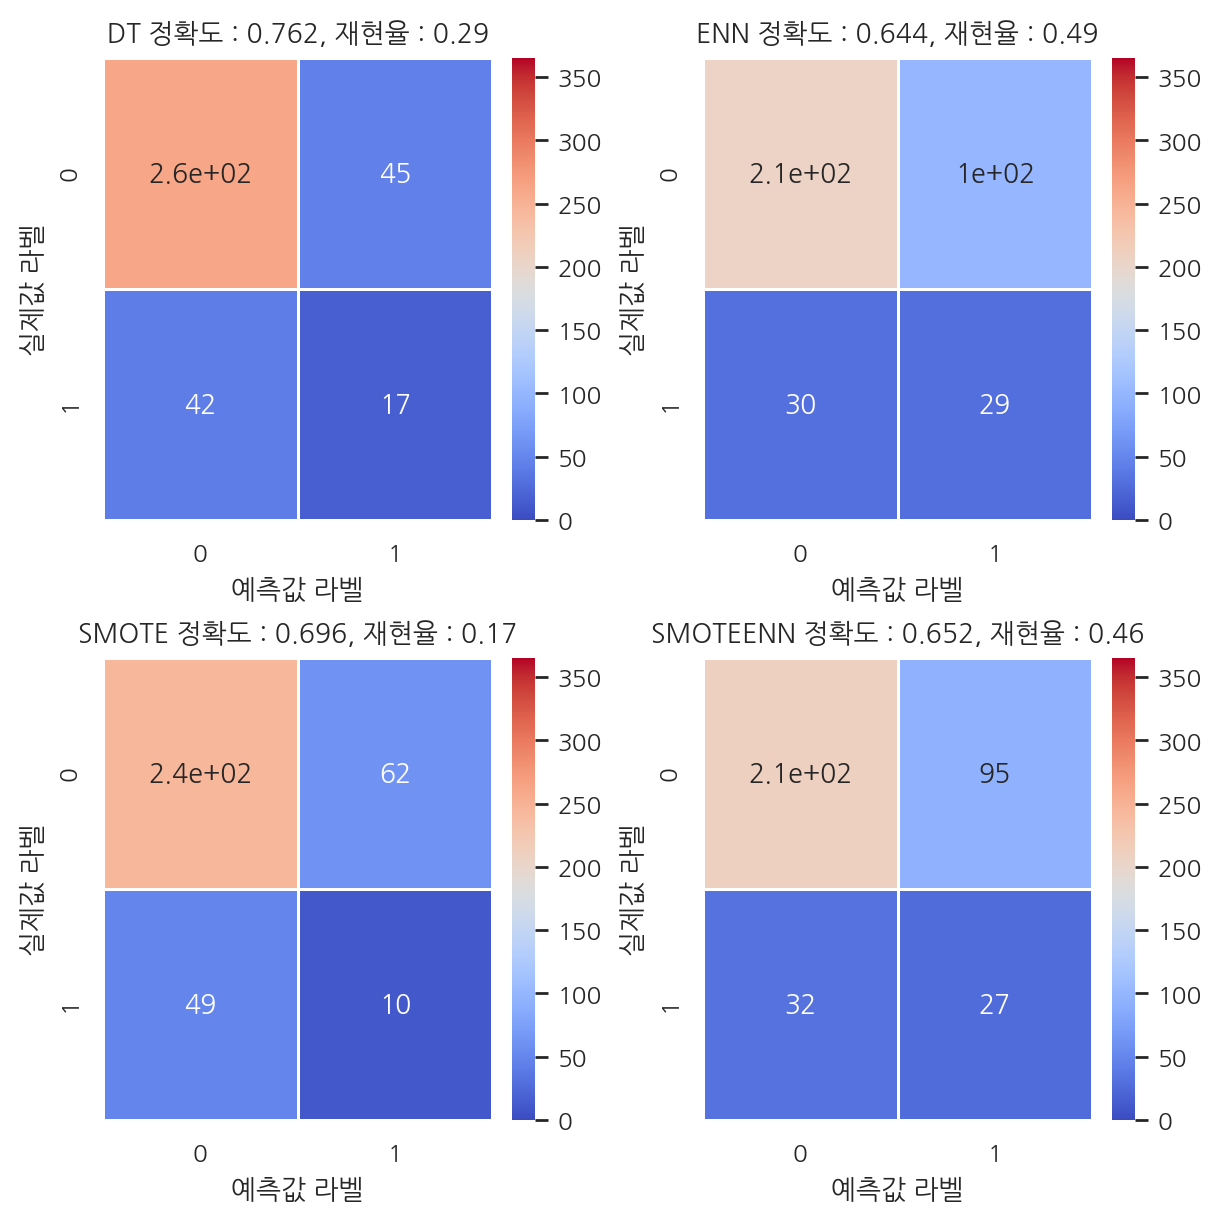

In [22]:
# 히트맵 그리기

fig, axes = plt.subplots(2,2, figsize=(6,6))
pred_dict = {
    "DT": pred_tree,
    "ENN": pred_tree_enn,
    "SMOTE" : pred_tree_smo,
    "SMOTEENN" : pred_tree_smoteenn
}

for name, ax  in zip(pred_dict.keys(), axes.flat):
  matrix = pred_dict[name]
  acc = round(accuracy_score(pred_dict[name], y_test), 3)
  recall = round(recall_score(y_test, pred_dict[name]), 2)

  sns.heatmap(data = confusion_matrix(y_test, matrix),
              cmap = "coolwarm",
              linecolor="white",
              linewidth=1,
              annot=True,
              vmax = 365,
              vmin=0,
              ax=ax
              )
  title = f"{name} 정확도 : {acc}, 재현율 : {recall}"
  ax.set(xlabel = "예측값 라벨",
         ylabel = "실제값 라벨",
         title = title)

# 3. AUC-ROC Curve

- 이진분류 모델의 성능평가에 사용
- FPR이 변할 때 TPR이 어떻게 변하는지를 그린 그래프

* TPR(True Positive Rate) = recall = 재현율 = 민감도

\begin{equation}
\text{TPR} = \frac{\text{TP}}{\text{FN+TP}}
\end{equation}

* TNR(True Negative Rate) = specificity = 특이성

\begin{equation}
\text{TNR} = \frac{\text{TN}}{\text{TN+FP}}
\end{equation}

* FPR(False Positive Rate) = $1-$특이성

\begin{align}
\text{FPR} &= 1-\text{TNR}\\
&=\frac{\text{FP}}{\text{TN+FP}}
\end{align}

In [23]:
print(classification_report(y_test, pred_tree))

              precision    recall  f1-score   support

           0       0.86      0.85      0.86       306
           1       0.27      0.29      0.28        59

    accuracy                           0.76       365
   macro avg       0.57      0.57      0.57       365
weighted avg       0.77      0.76      0.76       365



In [24]:
# 위에서 언급한 TPR(재현율(민감도)), TNR(특이성), FPR을 이용하여 ROC 그래프를 그려보자
tree_fpr, tree_tpr, tree_thr = roc_curve(y_test, tree.predict_proba(x_test)[:,1])
tree_enn_fpr, tree_enn_tpr, tree_enn_thr = roc_curve(y_test, tree_enn.predict_proba(x_test)[:,1])

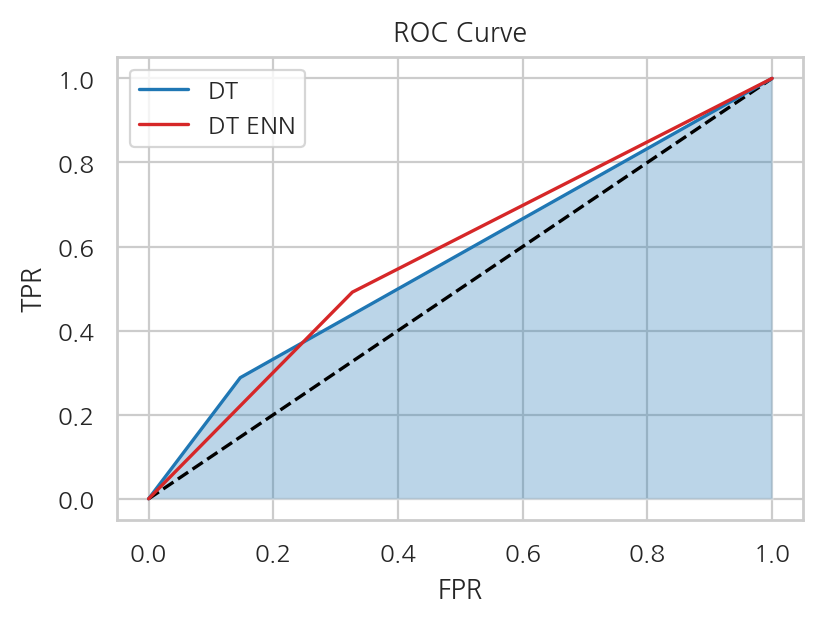

In [26]:
fig, ax = plt.subplots(figsize = (4,3))
ax.plot([0,1], [0,1], "k--")
ax.plot(tree_fpr,tree_tpr, label="DT", color="tab:blue")
ax.plot(tree_enn_fpr, tree_enn_tpr, label ="DT ENN" , color = "tab:red")

ax.fill_between(tree_fpr, tree_tpr, facecolor='tab:blue', alpha=0.3)
ax.set(xlabel="FPR", ylabel="TPR", title = "ROC Curve")
ax.legend()

- AUC score : ROC Curve 아래의 면적을 의미함.
- 정확도가 비슷하다면 넓을수록 좋은 모델이라고 판단.

In [27]:
print("AUC score of DT : ", roc_auc_score(y_test, tree.predict_proba(x_test)[:,1]))
print("AUC Score of DT ENN : ", roc_auc_score(y_test, tree_enn.predict_proba(x_test)[:,1]))
# 결과를 보면 정확도가 비슷하다.

AUC score of DT :  0.5705383848454637
AUC Score of DT ENN :  0.5823640190539493


In [28]:
# Confusion Matrix로 코드 출력 형식으로 보기
confusion_matrix(y_test, pred_tree)

array([[261,  45],
       [ 42,  17]])

In [29]:
# Classification report로 표 출력 형식으로 보기
print(classification_report(y_test, pred_tree))

              precision    recall  f1-score   support

           0       0.86      0.85      0.86       306
           1       0.27      0.29      0.28        59

    accuracy                           0.76       365
   macro avg       0.57      0.57      0.57       365
weighted avg       0.77      0.76      0.76       365



In [32]:
# thresold
thr = 0.3
pred_thr = tree.predict_proba(x_test)[:,1]>thr

tn = len([i for i in range(len(y_test)) if (y_test.iloc[i] == 0) and (pred_thr[i] == 0)])
fp = len([i for i in range(len(y_test)) if (y_test.iloc[i] == 0) and (pred_thr[i] == 1)])
fn = len([i for i in range(len(y_test)) if (y_test.iloc[i] == 1) and (pred_thr[i] == 0)])
tp = len([i for i in range(len(y_test)) if (y_test.iloc[i] == 1) and (pred_thr[i] == 1)])

print("TPR: ", tp/(fn+tp))
print("FPR: ", fp/(tn+fp))

TPR:  0.288135593220339
FPR:  0.14705882352941177


In [35]:
# thr를 0부터 1까지 0.1씩 증가시키며 tpr과 fpr을 계산
tpr = [1]
fpr = [1]
for thr in np.arange(0, 1.1, 0.1):
    pred_thr = tree.predict_proba(x_test)[:,1]>thr

    tn = len([i for i in range(len(y_test)) if (y_test.iloc[i] == 0) and (pred_thr[i] == 0)])
    fp = len([i for i in range(len(y_test)) if (y_test.iloc[i] == 0) and (pred_thr[i] == 1)])
    fn = len([i for i in range(len(y_test)) if (y_test.iloc[i] == 1) and (pred_thr[i] == 0)])
    tp = len([i for i in range(len(y_test)) if (y_test.iloc[i] == 1) and (pred_thr[i] == 1)])

    tpr.append(tp/(fn+tp))
    fpr.append(fp/(tn+fp))

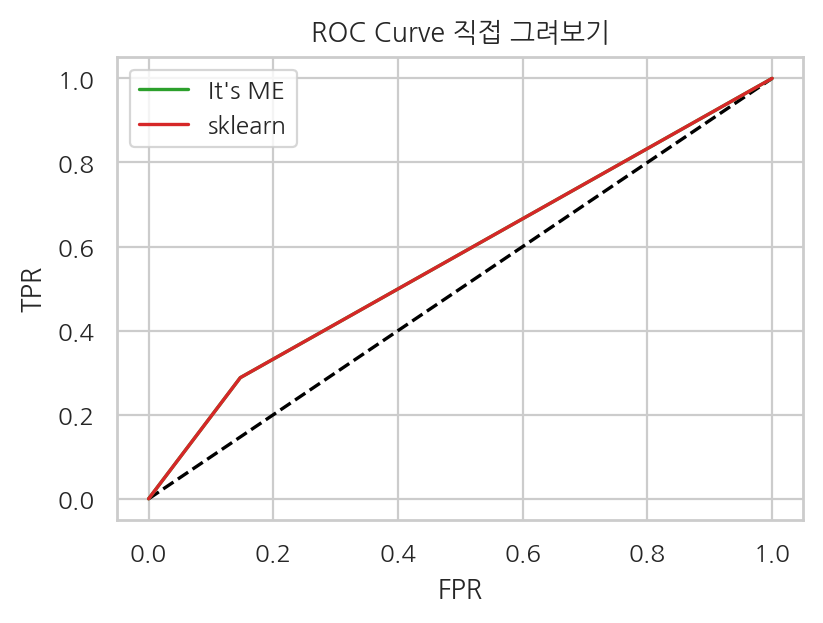

In [36]:
fig, ax = plt.subplots(figsize=(4,3))
ax.plot([0,1], [0,1], "k--")
ax.plot(fpr, tpr, label="It's ME", color = "tab:green")
ax.plot(tree_fpr, tree_tpr, label="sklearn", color = "tab:red")

ax.set(xlabel="FPR", ylabel="TPR", title = "ROC Curve 직접 그려보기")
ax.legend();